In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

import re
from urllib.request import urlopen
from urllib.parse import urlparse
from urllib.error import HTTPError

In [2]:
from settings import *

## Read Data

In [70]:
query = """
select *
from 
(select id, body, doc_type
from document
where doc_type = 'web'
limit 100) t1
UNION
(select id, body, doc_type
from document
where doc_type = 'twitter'
limit 100)
"""


documents = queryDB(query, 'smeros', '', 'sciArticles')
documents = documents.set_index('id')

In [71]:
def extractLinks(documents):

    urlRegex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    
    documents = documents.copy(deep=True)
    documents['body'] = documents['body'].apply(lambda x: re.findall(urlRegex, x)).to_frame()
    documents.rename(columns={'body': 'urls'}, inplace=True)
    
    return documents
extractLinks(documents)

,urls,doc_type
id,,
c3da73a8-9109-11e5-8cb6-42010af074fc,[],twitter
594f03aa-96fd-11e6-9d0c-0242ac110003,[],web
259c3ed8-5315-11e5-b5bc-42010af0793b,[http://goo.gl/P5cf],twitter
222e0f2a-9175-11e6-bd11-0242ac110003,[],web
34d05414-8bb7-11e5-824d-42010af074fc,[http://t.co/7jZuPXBfOW],twitter
d9c40736-4656-11e5-8e33-42010af074fc,[http://bit.ly/9OvIjO],twitter
5045b026-9174-11e6-ac75-0242ac110003,[http://atozresearch.com/global-fast-food-mark...,web
45c45478-9178-11e6-8142-0242ac110003,[],web
d9c3ceba-4656-11e5-8e33-42010af074fc,[http://bit.ly/bRJn6h.],twitter


In [72]:
def countLinks(documents):
    documents = documents.copy(deep=True)
    documents = extractLinks(documents)
    documents['urls'] = documents['urls'].apply(lambda x: len(x))
    return documents.groupby(['doc_type','urls']).size()

def plotCountLinks(documents):
    count = countLinks(documents)
    docs = {}
    for doc_type in count.index.levels[0]:
        urls=[]
        for urlNum in count.index.levels[1]:
            urls.append(count.get((doc_type, urlNum),0))
        docs[doc_type]=urls

    
    both=pd.DataFrame(docs, index=count.index.levels[1])
    twitter=both['twitter'][lambda x: x!=0]
    web=both['web'][lambda x: x!=0]
 
    return both, twitter, web

bothCount, twitterCount, webCount = plotCountLinks(documents)

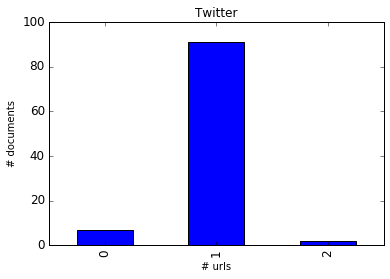

In [74]:
ax = twitterCount.plot.bar(fontsize=12, color='b', title='Twitter')
ax.set_xlabel("# urls")
ax.set_ylabel("# documents")

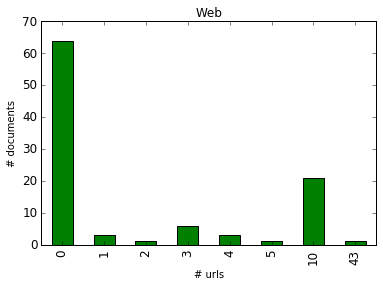

In [75]:
ax = webCount.plot.bar(fontsize=12, color='g', title='Web')
ax.set_xlabel("# urls")
ax.set_ylabel("# documents")

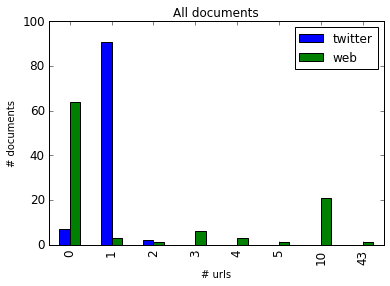

In [78]:
ax = bothCount.plot.bar(fontsize=12, color='bg', title='All documents')
ax.set_xlabel("# urls")
ax.set_ylabel("# documents")

In [ ]:
def flattenLinks(documents):
    
    #documentsWithUrl = documents.where(documents['urls'].apply(lambda x: len(x)!=0)).dropna(how='all')
    #documentsWithoutUrl = documents.where(documents['urls'].apply(lambda x: len(x)==0))['id'].dropna(how='all')
    
    l = pd.DataFrame([(row[1], link) for row in documents.itertuples() for link in row[2]])
    print (l)
        
    
documents1 = flattenLinks(documents.head(50))

In [ ]:
                                                
#     documents = pd.DataFrame(pd.concat([documents['id'], urls], axis=1))
#     documents.set_index('id')
        
    
#     def test(x):
#         d = {}
#         for url in x['urls']:
#             d(x['id']) = url
    
#     a = documents.apply(lambda x : test(x), axis=1)
    
    
    
    
#     print(a)
    
#     print(documents)
    
    def resolveURLs(urls):

        if (removeDuplicateLinks):
            urls = set(urls)
            
        resolvedURLs = pd.DataFrame
        unresolvedURLs = pd.DataFrame

        for url in urls:
            try:
                resolvedURL = urlopen(url,timeout=10).geturl()
                
                if(urlparse(resolvedURL).netloc.endswith('.ly')):
                    print('not resolved: ' + url)
                    unresolvedURLs.append(url)
                    continue
                
                print ('resolved: ' + resolvedURL)
                resolvedURLs.append(resolvedURL)
            except HTTPError as e:
                print (e.code)
                print('not resolved: ' + url)
                resolvedURLs.append('DeadLink')
        #return [session.head(url, allow_redirects=True).url for url in urls]
    
    

    
    
    #urls = urls.apply(lambda x: resolveURLs(x))
    
    print(urls.shape)
    
    #Checks resolvability of URLs
    #resolvableURLs = urls.apply(pd.Series).applymap(lambda x: None if pd.isnull(x) else requests.get(x, verify=False).status_code==200)
    #resolvableURLs = pd.Series(np.logical_or.reduce(resolvableURLs, axis=1), name="hasResolvableURLs")
    #print (resolvableURLs.shape)


    return documents

documents1 = extractURLs(documents.head(50))

In [ ]:


#tweets1 = extractURLs(tweets)

print (tweets1['urls'][0:10])

#conn.setopt(pycurl.URL, "http://t.co/yzUy11usmg")
#conn.setopt(pycurl.URL, "http://t.co/cEVKs7ewVN")

In [ ]:
print (urls)